# Importing and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import re

from nltk.collocations import *
from itertools import chain
from tqdm import tqdm
tqdm.pandas()

from nltk.stem import WordNetLemmatizer
from string import punctuation
  
lemmatizer = WordNetLemmatizer()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
""" Please run appropriate command to import the file."""

with open("/content/drive/MyDrive/Syracuse University/IST 664 Natural Language Processing/Assignment 1/clothing_shoes_jewelry.txt",'r') as f:
  txt = f.read()

# with open('/drive/My Drive/Colab Notebooks/Mon_Homework1/clothing_shoes_jewelry.txt', 'r') as f:
#   txt = f.read() 

In [4]:
txt_split = txt.split("\n\n")

In [5]:
txt_split = txt_split[:-1]

In [6]:
txt_chunks = [tuple(t.split("\n")) for t in txt_split]

In [7]:
txt_dict = []
for i in txt_chunks:
    txt_dict.append(dict(tuple(t.split(":",maxsplit=1)) for t in i))

In [8]:
df = pd.DataFrame(txt_dict)

In [9]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [10]:
assert (df.groupby("reviewerID").size()>=5).all(), "Check Again! Minimum Reviews per user should be 5" # checking if the import was correct

In [11]:
assert (df.groupby("asin").size()>=5).all(), "Check Again! Minimum Reviews per item should be 5" # checking if the import was correct

In [12]:
df.shape

(278677, 9)

In [13]:
df = df[df.reviewText.progress_apply(len) > 0] # To remove Nulls 
df = df.iloc[:5000].reset_index(drop=True) # selecting just the first 5000 rows for this assignment

100%|██████████| 278677/278677 [00:00<00:00, 743353.23it/s]


In [14]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette = "crest_r")

<Axes: xlabel='overall', ylabel='count'>

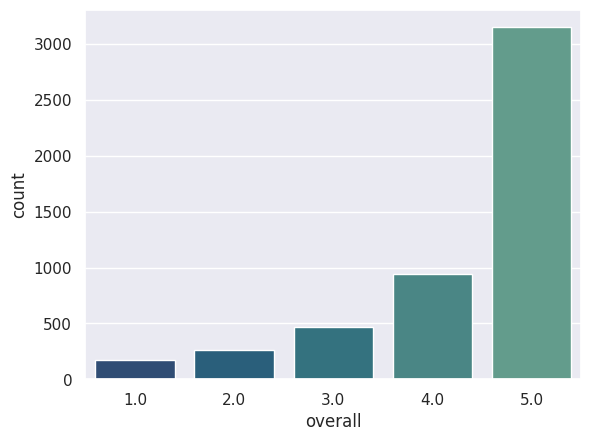

In [15]:
sns.countplot(x = df.overall, order=sorted(df.overall.unique())) # To check the spread of reviews over the ratings

In [16]:
df.unixReviewTime = pd.to_datetime(df.unixReviewTime, unit='s')

<Axes: xlabel='unixReviewTime', ylabel='count'>

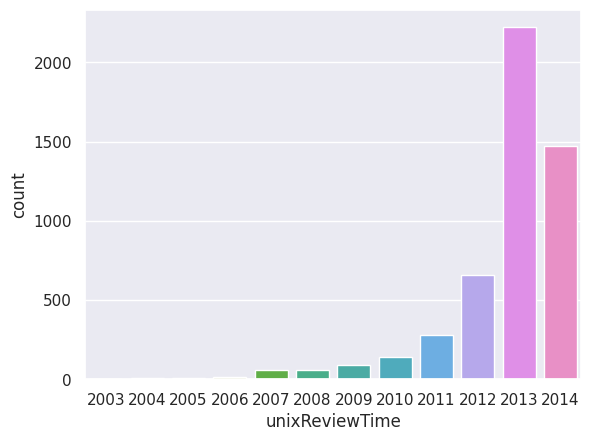

In [17]:
sns.countplot(x = df.unixReviewTime.dt.year, order = sorted(df.unixReviewTime.dt.year.unique())) # Checking years in which the review was given

In [18]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,2011-02-12,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,2013-01-19,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,2013-01-04,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",2014-04-27,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,2014-03-15,"03 15, 2014"


# PART 1

In [19]:
import nltk

In [20]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
df_rev = df[['reviewText']]

In [22]:
# Strategy 
# do sentense tokenize
# adjective words, capital word(s), or exclamation marks Calculate these:
# Sum up the columns by groupby on reviewText ID 
# If the sum is 0, remove reviews 
# Get Adjective Word List, Bigram List, Capital Word List, Exclaimation Mark 

In [23]:
df_rev = df_rev.rename_axis("reviewText_ID", axis = 0).reset_index() # Providing a unique id to each review

In [24]:
df_rev["reviewText_sents"] = df_rev.reviewText.progress_apply(nltk.sent_tokenize) # segmenting reviews into sentences

100%|██████████| 5000/5000 [00:00<00:00, 7615.15it/s]


In [25]:
df_rev = df_rev.explode('reviewText_sents') # exploding df such that each row has a sentence

In [26]:
# function to get list of adjectives from a given sentence
def get_adjective_word_list(sentence):
  word_list_w_tags = nltk.pos_tag(nltk.word_tokenize(sentence))
  return [i for i,j in word_list_w_tags if j in ['JJ', 'JJR', 'JJS']]
  # https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

# function to get list of capital words from a given sentence
capital_pattern = re.compile(r"\b[A-Z]+\b")
def get_capital_word_list(sentence):
  return re.findall(capital_pattern,sentence)

# function to say whether a given sentence has exclamation marks
def contains_exlamation_mark(sentence):
  if "!" in sentence:
    return 1
  return 0

# function to get bigrams which have either verbs or adjectives in it
# we make the bigrams first, then search for bigrams with Verbs or Adjectives
stopwords = nltk.corpus.stopwords.words('english')
list_vaid_tags_for_bigrams = ('VB','JJ')
def get_bigrams(sentence):
  bigrams_list_w_tags = nltk.bigrams(nltk.pos_tag(nltk.word_tokenize(sentence)))
  bigrams_list_w_tags = [i for i in bigrams_list_w_tags if (i[0][1].startswith(list_vaid_tags_for_bigrams)) | (i[1][1].startswith(list_vaid_tags_for_bigrams))]
  bigrams_list_w_tags = [i for i in bigrams_list_w_tags if (i[0][0].lower() not in stopwords) & (i[1][0].lower() not in stopwords)]
  bigrams_list_w_tags = [i for i in bigrams_list_w_tags if (i[0][0] not in punctuation) & (i[1][0] not in punctuation)] 
  return bigrams_list_w_tags

In [27]:
df_rev['adjective_words'] = df_rev['reviewText_sents'].progress_apply(get_adjective_word_list)
df_rev['capital_words'] = df_rev['reviewText_sents'].progress_apply(get_capital_word_list)
df_rev['contains_exclaimation'] = df_rev['reviewText_sents'].progress_apply(contains_exlamation_mark)

100%|██████████| 22032/22032 [00:00<00:00, 348741.80it/s]


In [28]:
# df_rev['capital_tokens'] = df_rev['tokenized_sentence'].progress_apply(lambda x: [i for i in x if re.match("^[A-Z]+$",i)])
# df_rev['has_exclaimation'] = df_rev['tokenized_sentence'].progress_apply(lambda x: int(any([i == "!" for i in x])))

In [29]:
# removing all sentences where the none of the 3 conditions are met 
df_rev = df_rev[~df_rev.progress_apply(lambda x: True 
                     if (len(x['adjective_words']) == 0) & (len(x['capital_words']) == 0) & (x['contains_exclaimation'] == 0)
                     else False, axis = 1)]

100%|██████████| 22032/22032 [00:00<00:00, 44827.49it/s]


In [30]:
df_rev['bigram_list_vb_adj'] = df_rev['reviewText_sents'].progress_apply(get_bigrams)

100%|██████████| 19209/19209 [00:22<00:00, 853.14it/s]


In [31]:
all_adjectives = list(chain(*df_rev.adjective_words)) # Concatenating all adjective lists to get one list
all_bigrams = list(chain(*df_rev.bigram_list_vb_adj)) # Concatenating all bigrams lists to get one list
all_bigrams = [(i[0][0], i[1][0]) for i in all_bigrams] # taking out words from bigrams which are word,pos_tag pairs
all_bigrams = [(lemmatizer.lemmatize(i[0]), lemmatizer.lemmatize(i[1])) for i in all_bigrams] # Lemmatizing to see the words clearly 

In [32]:
# calculation of length for various lists and strings
df_rev["reviewText_sent_len"] = df_rev["reviewText_sents"].progress_apply(len)
df_rev["bigrams_list_len"] = df_rev["bigram_list_vb_adj"].progress_apply(len)
df_rev["adjective_words_len"] = df_rev["adjective_words"].progress_apply(len)
df_rev["capital_words_len"] = df_rev["capital_words"].progress_apply(len)

100%|██████████| 19209/19209 [00:00<00:00, 351785.53it/s]


In [33]:
df_rev[['reviewText_sent_len', 'bigrams_list_len', 'adjective_words_len','capital_words_len']].describe() # descriptive statistics on lengths obtained

,reviewText_sent_len,bigrams_list_len,adjective_words_len,capital_words_len
count,19209.000000,19209.000000,19209.000000,19209.000000
mean,81.744911,1.954240,1.645947,0.900672
std,60.887768,1.932438,1.484599,2.198032
min,1.000000,0.000000,0.000000,0.000000
25%,44.000000,1.000000,1.000000,0.000000
50%,68.000000,2.000000,1.000000,1.000000
75%,103.000000,3.000000,2.000000,1.000000
max,1178.000000,32.000000,32.000000,180.000000


In [34]:
display(df_rev.contains_exclaimation.value_counts()) # In absolute counts
display(df_rev.contains_exclaimation.value_counts(normalize = True) * 100) # In Percentages

0    17199
1     2010
Name: contains_exclaimation, dtype: int64

0    89.536155
1    10.463845
Name: contains_exclaimation, dtype: float64

In [35]:
freq_adjectives = nltk.FreqDist(all_adjectives) # initializing for all adjective list 

In [36]:
freq_adjectives.most_common(50) # top 50 adjectives

[('great', 1180),
 ('good', 1105),
 ('comfortable', 1081),
 ('other', 679),
 ('little', 661),
 ('nice', 531),
 ('more', 495),
 ('small', 432),
 ('perfect', 425),
 ('last', 365),
 ('big', 359),
 ('long', 326),
 ('much', 315),
 ('same', 298),
 ('large', 294),
 ('few', 287),
 ('many', 285),
 ('best', 282),
 ('first', 278),
 ('better', 255),
 ('easy', 249),
 ('different', 249),
 ('new', 248),
 ('old', 245),
 ('happy', 230),
 ('only', 229),
 ('right', 225),
 ('black', 217),
 ('high', 210),
 ('larger', 200),
 ('durable', 200),
 ('several', 196),
 ('sure', 194),
 ('smaller', 194),
 ('hard', 189),
 ('fit', 189),
 ('thin', 184),
 ('tight', 181),
 ('warm', 180),
 ('true', 178),
 ('most', 177),
 ('soft', 163),
 ('light', 154),
 ('wide', 149),
 ('short', 143),
 ('fine', 137),
 ('heavy', 133),
 ('able', 129),
 ('second', 125),
 ('Good', 124)]

In [37]:
freq_bigrams = nltk.FreqDist(all_bigrams) 

In [38]:
freq_bigrams.most_common(50) # top 50 bigrams

## ANALYSIS : Most of the bigrams denote a positive sentiment and it is to be expected because we have very few low rated reviews.
# We can see that the most frequently occuring bigram is well made, which is good for the sales. Fourth Bigram that says long time 
# could be positive in the sense that the customers could use it for a long time but it may be bad if that is in relation to delivery
# times. Then we have bigrams like highly recommend and would recommend which are agian good news for the business. 

[(('well', 'made'), 110),
 (('look', 'great'), 104),
 (('fit', 'great'), 101),
 (('long', 'time'), 100),
 (('good', 'quality'), 100),
 (('look', 'good'), 94),
 (('feel', 'like'), 86),
 (('year', 'old'), 84),
 (('fit', 'well'), 84),
 (('highly', 'recommend'), 81),
 (('would', 'recommend'), 80),
 (('look', 'like'), 76),
 (('fit', 'perfectly'), 70),
 (("n't", 'know'), 63),
 (("n't", 'like'), 60),
 (('different', 'color'), 58),
 (('size', 'larger'), 56),
 (('normally', 'wear'), 54),
 (('right', 'size'), 50),
 (("n't", 'get'), 49),
 (("n't", 'wear'), 48),
 (('little', 'bit'), 47),
 (("n't", 'want'), 47),
 (("'ve", 'worn'), 46),
 (('many', 'year'), 45),
 (('high', 'quality'), 43),
 (('perfect', 'fit'), 43),
 (('size', 'smaller'), 43),
 (("n't", 'think'), 42),
 (("'ve", 'ever'), 42),
 (('much', 'better'), 42),
 (('go', 'wrong'), 42),
 (('first', 'time'), 40),
 (('light', 'weight'), 40),
 (("n't", 'go'), 40),
 (("n't", 'feel'), 40),
 (('usually', 'wear'), 39),
 (('first', 'pair'), 37),
 (('fee

In [39]:
file_path = "/content/drive/MyDrive/Syracuse University/IST 664 Natural Language Processing/Assignment 2" # Please change this path as per your drive.
file_name = "aadil_zikre_assignment_2_first_part_file.csv"

cols_to_export = ['reviewText_ID', 'reviewText', 'reviewText_sents', 'reviewText_sent_len', 
                  'adjective_words', 'bigram_list_vb_adj', 'capital_words', 'contains_exclaimation']
df_final = df_rev[cols_to_export].copy()
df_final['adjective_words'] = df_final['adjective_words'].progress_apply(lambda x: x if x else 0)
df_final['capital_words'] = df_final['capital_words'].progress_apply(lambda x: x if x else 0)
df_final.to_csv(f"{file_path}/{file_name}", index = False)
df_final.head()

100%|██████████| 19209/19209 [00:00<00:00, 419454.42it/s]


,reviewText_ID,reviewText,reviewText_sents,reviewText_sent_len,adjective_words,bigram_list_vb_adj,capital_words,contains_exclaimation
0,0,This is a great tutu and at a really great pri...,This is a great tutu and at a really great price.,49,"[great, great]","[((great, JJ), (tutu, NN)), ((really, RB), (gr...",0,0
0,0,This is a great tutu and at a really great pri...,It doesn't look cheap at all.,29,[cheap],"[((n't, RB), (look, VB)), ((look, VB), (cheap,...",0,0
0,0,This is a great tutu and at a really great pri...,I'm so glad I looked on Amazon and found such ...,88,"[glad, affordable]","[((affordable, JJ), (tutu, NN)), ((n't, RB), (...","[I, I]",0
0,0,This is a great tutu and at a really great pri...,A++,3,0,[],[A],0
1,1,I bought this for my 4 yr old daughter for dan...,I bought this for my 4 yr old daughter for dan...,133,"[old, first, adorable]","[((yr, RB), (old, JJ)), ((old, JJ), (daughter,...",[I],0


# PART 2

I have done the modelling on the dataset , the sentence polarity corpus. 

My first model produced higher accuracy as well higher recall for both categories, so I decided to go ahead with that for the final predictions for the actual reviewText dataset. 

Features used for the first model:
 Most common 2000 words occuring in the corpus after removing stop words and puncutaions only words from the corpus. <br>
Features used in the second model:
 I took the most common 2000 words again but this time I also did lemmatization along with removal of stop words and punctuations only words. I also handled negation here. 

In [40]:
import nltk
nltk.download('sentence_polarity')
from nltk.corpus import sentence_polarity
import random

sentences = sentence_polarity.sents()
print(len(sentences))
print(sentence_polarity.categories())

for sent in sentences[:4]:
    print(sent)

pos_sents = sentence_polarity.sents(categories='pos') # accumulating positive sentences
print(len(pos_sents)) # total positive sentences
neg_sents = sentence_polarity.sents(categories='neg') # accumulating negative sentences
print(len(neg_sents)) # total negative sentences

[nltk_data] Downloading package sentence_polarity to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/sentence_polarity.zip.


10662
['neg', 'pos']
['simplistic', ',', 'silly', 'and', 'tedious', '.']
["it's", 'so', 'laddish', 'and', 'juvenile', ',', 'only', 'teenage', 'boys', 'could', 'possibly', 'find', 'it', 'funny', '.']
['exploitative', 'and', 'largely', 'devoid', 'of', 'the', 'depth', 'or', 'sophistication', 'that', 'would', 'make', 'watching', 'such', 'a', 'graphic', 'treatment', 'of', 'the', 'crimes', 'bearable', '.']
['[garbus]', 'discards', 'the', 'potential', 'for', 'pathological', 'study', ',', 'exhuming', 'instead', ',', 'the', 'skewed', 'melodrama', 'of', 'the', 'circumstantial', 'situation', '.']
5331
5331


In [41]:
# Making one big document list. 
# It should contain ( sentence, category ) pairs for each sentence and all polarity types, which in this case is pos and neg

documents = [(sent, cat) for cat in sentence_polarity.categories() 
	for sent in sentence_polarity.sents(categories=cat)]

for i in range(5):
  print(documents[i])

for i in range(5):
  print(documents[-i])


(['simplistic', ',', 'silly', 'and', 'tedious', '.'], 'neg')
(["it's", 'so', 'laddish', 'and', 'juvenile', ',', 'only', 'teenage', 'boys', 'could', 'possibly', 'find', 'it', 'funny', '.'], 'neg')
(['exploitative', 'and', 'largely', 'devoid', 'of', 'the', 'depth', 'or', 'sophistication', 'that', 'would', 'make', 'watching', 'such', 'a', 'graphic', 'treatment', 'of', 'the', 'crimes', 'bearable', '.'], 'neg')
(['[garbus]', 'discards', 'the', 'potential', 'for', 'pathological', 'study', ',', 'exhuming', 'instead', ',', 'the', 'skewed', 'melodrama', 'of', 'the', 'circumstantial', 'situation', '.'], 'neg')
(['a', 'visually', 'flashy', 'but', 'narratively', 'opaque', 'and', 'emotionally', 'vapid', 'exercise', 'in', 'style', 'and', 'mystification', '.'], 'neg')
(['simplistic', ',', 'silly', 'and', 'tedious', '.'], 'neg')
(['provides', 'a', 'porthole', 'into', 'that', 'noble', ',', 'trembling', 'incoherence', 'that', 'defines', 'us', 'all', '.'], 'pos')
(["it's", 'nice', 'to', 'see', 'piscopo',

In [42]:
from string import punctuation

In [43]:
[word for word in ['aadil','--'] if not all(c in punctuation for c in word)]

['aadil']

In [44]:
random.shuffle(documents)

stopwords = nltk.corpus.stopwords.words('english')

all_words_list = [word for (sent,cat) in documents for word in sent] # accumulating all words from all sentences in document
all_words_list = [word for word in all_words_list if word.lower() not in stopwords] # remove stop_words
all_words_list = [word for word in all_words_list if not all(c in punctuation for c in word)] # remove tokens which are only punctuations
all_words = nltk.FreqDist(all_words_list)

word_items = all_words.most_common(2000) # selecting top 2000 words for first model
word_features = [word for (word,count) in word_items]
print(word_features[:50])

['film', 'movie', 'one', 'like', 'story', 'much', 'even', 'good', 'comedy', 'time', 'characters', 'little', 'way', 'funny', 'make', 'enough', 'never', 'makes', 'may', 'us', 'work', 'best', 'bad', 'director', 'love', 'would', 'life', "there's", 'movies', 'new', 'well', 'could', 'something', 'really', 'made', 'performances', 'drama', 'many', "that's", 'plot', 'look', 'films', 'every', 'still', 'see', 'two', 'nothing', 'people', 'better', 'without']


In [45]:
""" CLASSIFIER 1 : 
Type : Naive Bayes Classifier 
Features : 2000 Boolean features which state whether any token matches the reference tokens. 
Preprocessing to get the reference tokens : 
  1. Tokenization
  2. Stop Words Removal 
  3. Punctuations only Token removal 
Training: All documents after first 1000 documents
Testing: First 1000 documents
Result: Accuracy = 0.72 | F1 Score (pos) = 0.72 | F1 Score (neg) = 0.72
  We can see that the accuracy is 72 % and F1 Score for positive and negative is almost similar. Thats a good indication that the model is 
  not biased towards any one class. 
"""

' CLASSIFIER 1 : \nType : Naive Bayes Classifier \nFeatures : 2000 Boolean features which state whether any token matches the reference tokens. \nPreprocessing to get the reference tokens : \n  1. Tokenization\n  2. Stop Words Removal \n  3. Punctuations only Token removal \nTraining: All documents after first 1000 documents\nTesting: First 1000 documents\nResult: Accuracy = 0.72 | F1 Score (pos) = 0.72 | F1 Score (neg) = 0.72\n  We can see that the accuracy is 72 % and F1 Score for positive and negative is almost similar. Thats a good indication that the model is \n  not biased towards any one class. \n'

In [46]:
# function to convert strings into word features
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features: # Iterating through word features which are top 2000 words appearing in our training corpus
        features['V_{}'.format(word)] = (word in document_words) # This will return True or False depending on whether the word is present in document
    return features

featuresets = [(document_features(d, word_features), c) for (d, c) in documents] # making sentence, polarity pairs for training the model

print(featuresets[0])

({'V_film': False, 'V_movie': False, 'V_one': True, 'V_like': False, 'V_story': False, 'V_much': False, 'V_even': False, 'V_good': False, 'V_comedy': False, 'V_time': False, 'V_characters': False, 'V_little': False, 'V_way': False, 'V_funny': False, 'V_make': False, 'V_enough': False, 'V_never': False, 'V_makes': True, 'V_may': False, 'V_us': True, 'V_work': False, 'V_best': False, 'V_bad': False, 'V_director': True, 'V_love': False, 'V_would': False, 'V_life': False, "V_there's": False, 'V_movies': False, 'V_new': False, 'V_well': False, 'V_could': False, 'V_something': False, 'V_really': False, 'V_made': False, 'V_performances': False, 'V_drama': False, 'V_many': False, "V_that's": False, 'V_plot': False, 'V_look': False, 'V_films': False, 'V_every': False, 'V_still': False, 'V_see': False, 'V_two': False, 'V_nothing': False, 'V_people': False, 'V_better': False, 'V_without': False, 'V_long': False, 'V_get': False, 'V_fun': False, 'V_action': False, 'V_great': True, 'V_though': False

In [47]:
len(featuresets) # total documents ( rows )

10662

In [48]:
train_set, test_set = featuresets[1000:], featuresets[:1000] # taking the first 1000 documents as test and remaining documents as train set
classifier = nltk.NaiveBayesClassifier.train(train_set) # fitting the naive bayes classifier

nltk.classify.accuracy(classifier, test_set) # calculating accuracy on the classifier

0.722

In [49]:
classifier.show_most_informative_features(30)
# One can read this as this. Lets take first example v_engrossing, one can say its odds of appearing in a positive sentence is 19 is to 1

Most Informative Features
               V_tedious = True              neg : pos    =     19.1 : 1.0
              V_mediocre = True              neg : pos    =     15.7 : 1.0
               V_generic = True              neg : pos    =     15.1 : 1.0
                  V_flat = True              neg : pos    =     14.3 : 1.0
                    V_90 = True              neg : pos    =     13.7 : 1.0
                  V_loud = True              neg : pos    =     13.7 : 1.0
                V_boring = True              neg : pos    =     12.8 : 1.0
                  V_lame = True              neg : pos    =     12.4 : 1.0
                 V_stale = True              neg : pos    =     11.7 : 1.0
            V_refreshing = True              pos : neg    =     11.6 : 1.0
                  V_warm = True              pos : neg    =     11.3 : 1.0
             V_wonderful = True              pos : neg    =     11.3 : 1.0
             V_realistic = True              pos : neg    =     11.0 : 1.0

In [50]:
# loop to capture actual and predicted tags for documents in the test set
res_tup = []
for doc, act_tag in tqdm(test_set):
  pred_tag = classifier.classify(doc)
  res_tup.append((doc, act_tag, pred_tag))

100%|██████████| 1000/1000 [00:09<00:00, 104.14it/s]


In [51]:
df_test_res = pd.DataFrame(res_tup, columns = ['document', 'actual_tag', 'predicted_tag']) # making a dataframe

In [52]:
import sklearn.metrics as sm 

In [53]:
print(sm.classification_report(df_test_res['actual_tag'], df_test_res['predicted_tag'])) # printing classification report for precision recall and accuracy

              precision    recall  f1-score   support

         neg       0.74      0.71      0.72       511
         pos       0.71      0.73      0.72       489

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



In [54]:
""" CLASSIFIER 2 : 
Type : Naive Bayes Classifier 
Features : 4000+ Boolean features which state whether any token matches the reference tokens. 
  Reference features that begin with V_ are normal words, and V_NOT are negation words (user defined)
Preprocessing to get the reference tokens : 
  1. Tokenization
  2. Lemmatization 
  3. Stop Words Removal by lowercasing the tokens temporarily 
  4. Punctuations only Tokens removal 
  5. Handling negation by defining negation words
Training: All documents after first 1000 documents
Testing: First 1000 documents
Result: Accuracy = 0.79 | F1 Score (pos) = 0.78 | F1 Score (neg) = 0.79
  We can see that the accuracy is 79 % and F1 Score for positive and negative is almost similar. Thats a good indication that the model is 
  not biased towards any one class. Also, when compared to the previous model, the accuracy has increased by 7% which is huge, so definitely 
  preprocessing more heavily worked in our favour. Hence, we will use the second model as the final model for the prediction.
"""

' CLASSIFIER 2 : \nType : Naive Bayes Classifier \nFeatures : 4000+ Boolean features which state whether any token matches the reference tokens. \n  Reference features that begin with V_ are normal words, and V_NOT are negation words (user defined)\nPreprocessing to get the reference tokens : \n  1. Tokenization\n  2. Lemmatization \n  3. Stop Words Removal by lowercasing the tokens temporarily \n  4. Punctuations only Tokens removal \n  5. Handling negation by defining negation words\nTraining: All documents after first 1000 documents\nTesting: First 1000 documents\nResult: Accuracy = 0.79 | F1 Score (pos) = 0.78 | F1 Score (neg) = 0.79\n  We can see that the accuracy is 79 % and F1 Score for positive and negative is almost similar. Thats a good indication that the model is \n  not biased towards any one class. Also, when compared to the previous model, the accuracy has increased by 7% which is huge, so definitely \n  preprocessing more heavily worked in our favour. Hence, we will use

In [55]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer() # Initializing lemmatizer

In [56]:
negationwords = ['no', 'not', 'never', 'none', 'nowhere', 'nothing', 'noone', 'rather', 'hardly', 'scarcely', 'rarely', 'seldom', 'neither', 'nor']

def NOT_features(document, word_features, negationwords):
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = False
        features['V_NOT{}'.format(word)] = False
    # go through document words in order
    for i in range(0, len(document)):
        word = document[i]
        if ((i + 1) < len(document)) and ((word in negationwords) or (word.endswith("n't"))):
            i += 1
            features['V_NOT{}'.format(document[i])] = (document[i] in word_features)
        else:
            features['V_{}'.format(word)] = (word in word_features)
    return features


In [57]:
random.shuffle(documents)

all_words_list_lemmatized = [lemmatizer.lemmatize(word) for (sent,cat) in documents for word in sent] # lemmatizing the word at the time of collection
all_words_list_lemmatized = [word for word in all_words_list_lemmatized if word.lower() not in stopwords] # remove stop_words
all_words_list_lemmatized = [word for word in all_words_list_lemmatized if not all(c in punctuation for c in word)] # remove tokens which are only punctuations
all_words_lemmatized = nltk.FreqDist(all_words_list_lemmatized)

word_items_lemmatized = all_words_lemmatized.most_common(2000) # again selecting top 2000 words for the model training features
word_features_lemmatized = [word for (word,count) in word_items_lemmatized]

print(word_features[0:50])
print(word_features_lemmatized[0:50])

['film', 'movie', 'one', 'like', 'story', 'much', 'even', 'good', 'comedy', 'time', 'characters', 'little', 'way', 'funny', 'make', 'enough', 'never', 'makes', 'may', 'us', 'work', 'best', 'bad', 'director', 'love', 'would', 'life', "there's", 'movies', 'new', 'well', 'could', 'something', 'really', 'made', 'performances', 'drama', 'many', "that's", 'plot', 'look', 'films', 'every', 'still', 'see', 'two', 'nothing', 'people', 'better', 'without']
['film', 'movie', 'one', 'like', 'ha', 'make', 'story', 'character', 'time', 'much', 'comedy', 'even', 'good', 'way', 'work', 'performance', 'little', 'funny', 'life', 'feel', 'get', 'enough', 'never', 'u', 'director', 'may', 'thing', 'best', 'love', 'bad', 'look', 'would', 'take', 'wa', 'come', "there's", 'well', 'new', 'could', 'something', 'really', 'made', 'audience', 'drama', 'see', 'doe', "that's", 'plot', 'many', 'still']


In [58]:
# define the feature sets
NOT_featuresets = [(NOT_features(d, word_features_lemmatized, negationwords), c) for (d, c) in documents]
# show the values of a couple of example features
print(NOT_featuresets[0][0]['V_NOTcare'])
print(NOT_featuresets[0][0]['V_always'])

False
False


In [59]:
train_set_2, test_set_2 = NOT_featuresets[1000:], NOT_featuresets[:1000]
classifier_2 = nltk.NaiveBayesClassifier.train(train_set_2) # fitting the second classifier

nltk.classify.accuracy(classifier_2, test_set_2) # accuracy: we can see that the accuracy is less

0.768

In [60]:
# capturing predicted tags from this new model
res_tup = []
for doc, act_tag in tqdm(test_set_2):
  pred_tag = classifier_2.classify(doc)
  res_tup.append((doc, act_tag, pred_tag))

100%|██████████| 1000/1000 [00:13<00:00, 75.93it/s]


In [61]:
df_test_res_2 = pd.DataFrame(res_tup, columns = ['document', 'actual_tag', 'predicted_tag'])

In [62]:
print(sm.classification_report(df_test_res_2['actual_tag'], df_test_res_2['predicted_tag'])) # metrics like precision recall f1 score for second model

              precision    recall  f1-score   support

         neg       0.76      0.80      0.78       504
         pos       0.78      0.74      0.76       496

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



In [63]:
# reading the file for second part at the below location. Please change the variable file path as per the requirement
file_path = "/content/drive/MyDrive/Syracuse University/IST 664 Natural Language Processing/Assignment 2" # Please change this path as per your drive.
file_name = "aadil_zikre_assignment_2_first_part_file.csv"
df_orig = pd.read_csv(f"{file_path}/{file_name}")

In [64]:
def nb_predict(text, classifier, with_negation = False):
  texttokens = nltk.word_tokenize(text)
  if with_negation:
    texttokens = [lemmatizer.lemmatize(i) for i in texttokens]
    texttokens = [word for word in texttokens if word.lower() not in stopwords] # remove stop_words
    texttokens = [word for word in texttokens if not all(c in punctuation for c in word)] # remove tokens which are only punctuations
    inputfeatureset = NOT_features(texttokens, word_features_lemmatized, negationwords)
  else:
    texttokens = [word for word in texttokens if word.lower() not in stopwords] # remove stop_words
    texttokens = [word for word in texttokens if not all(c in punctuation for c in word)] # remove tokens which are only punctuations
    inputfeatureset = document_features(texttokens, word_features)
  return classifier.classify(inputfeatureset)

In [65]:
df_orig["polarity_pred_m1"] = df_orig["reviewText_sents"].progress_apply(lambda x: nb_predict(x, classifier))

100%|██████████| 19209/19209 [02:34<00:00, 124.26it/s]


In [ ]:
df_orig["polarity_pred_m2"] = df_orig["reviewText_sents"].progress_apply(lambda x: nb_predict(x, classifier_2, True))

100%|██████████| 19209/19209 [04:54<00:00, 65.29it/s]


In [ ]:
display(df_orig.polarity_pred_m1.value_counts())
display(df_orig.polarity_pred_m2.value_counts())
# Classifier 2 is a better classifier and we use it instead of 1 for further analysis 

neg    12012
pos     7197
Name: polarity_pred_m1, dtype: int64

neg    11598
pos     7611
Name: polarity_pred_m2, dtype: int64

In [ ]:
df_p2 = df_orig.groupby("reviewText")["polarity_pred_m2"].value_counts().rename("polarity_count_").reset_index()

In [ ]:
df_p2 = df_p2.set_index(["reviewText","polarity_pred_m2"]).unstack(fill_value=0).reset_index().rename_axis([None,None], axis = 1)

In [ ]:
df_p2.columns = [f"{i}{j}"for i,j in df_p2.columns]

In [ ]:
df_p2.head()

,reviewText,polarity_count_neg,polarity_count_pos
0,"&#34;That's what she said&#34; jokes aside, th...",4,0
1,&#34;What is thaaaat?!?&#34; That was the shri...,5,2
2,** PLEASE NOTE ** I was new to amazon at the ...,14,0
3,... but I am not an acrobat. Takes me more ti...,2,0
4,"... my clothes on-line, I hate sending stuff b...",3,0


In [ ]:
df_p2.query("polarity_count_neg > 0 & polarity_count_pos > 0").shape[0]/df_p2.shape[0]

0.621801329840822

In [ ]:
# storing the file for second part at the below location. Please change the variable file path as per the requirement
file_path = "/content/drive/MyDrive/Syracuse University/IST 664 Natural Language Processing/Assignment 2" # Please change this path as per your drive.
file_name = "aadil_zikre_assignment_2_second_part_file.csv"
df_p2.to_csv(f"{file_path}/{file_name}", index=False)

In [ ]:
df_p3_pos = df_orig.query("polarity_pred_m2 == 'pos'")
df_p3_neg = df_orig.query("polarity_pred_m2 == 'neg'")

In [ ]:
def get_word_list_adj_vb_advb(sentence):
  word_list_w_tags = nltk.pos_tag(nltk.word_tokenize(sentence)) # tagging the sentences after tokenization
  adj_words = [] # defining the lists
  vb_words = []
  advb_words = []
  for i,j in word_list_w_tags:
    i = lemmatizer.lemmatize(i)
    if j.startswith("JJ") : adj_words.append(i) # will add any JJ variant
    if j.startswith("VB"): vb_words.append(i)   # will add any VB variant
    if j.startswith("RB"): advb_words.append(i) # will add any RB variant
  return adj_words,vb_words,advb_words
  # https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [ ]:
df_p3_pos[['list_adjectives', 'list_verbs', 'list_adverbs']] = df_p3_pos.progress_apply(lambda x: get_word_list_adj_vb_advb(x["reviewText_sents"]), axis=1, result_type='expand')

100%|██████████| 7611/7611 [00:09<00:00, 792.88it/s]
<ipython-input-76-277960df8e3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p3_pos[['list_adjectives', 'list_verbs', 'list_adverbs']] = df_p3_pos.progress_apply(lambda x: get_word_list_adj_vb_advb(x["reviewText_sents"]), axis=1, result_type='expand')
<ipython-input-76-277960df8e3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p3_pos[['list_adjectives', 'list_verbs', 'list_adverbs']] = df_p3_pos.progress_apply(lambda x: get_word_list_adj_vb_

In [ ]:
df_p3_neg[['list_adjectives', 'list_verbs', 'list_adverbs']] = df_p3_neg.progress_apply(lambda x: get_word_list_adj_vb_advb(x["reviewText_sents"]), axis=1, result_type='expand')

100%|██████████| 11598/11598 [00:15<00:00, 763.24it/s]
<ipython-input-77-ad53a936411e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p3_neg[['list_adjectives', 'list_verbs', 'list_adverbs']] = df_p3_neg.progress_apply(lambda x: get_word_list_adj_vb_advb(x["reviewText_sents"]), axis=1, result_type='expand')
<ipython-input-77-ad53a936411e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p3_neg[['list_adjectives', 'list_verbs', 'list_adverbs']] = df_p3_neg.progress_apply(lambda x: get_word_list_adj_v

In [ ]:
# accumulating words for the analysis
pos_adjectives = list(chain(*df_p3_pos.list_adjectives))
pos_verbs = list(chain(*df_p3_pos.list_verbs))
pos_adverbs = list(chain(*df_p3_pos.list_adverbs))

pos_verbs = [i for i in pos_verbs if i not in stopwords]
pos_verbs = [i for i in pos_verbs if len(i) > 3]
pos_adverbs = [i for i in pos_adverbs if i not in stopwords]
pos_adverbs = [i for i in pos_adverbs if len(i) > 3]

In [ ]:
# accumulating negative words for the analysis
neg_adjectives = list(chain(*df_p3_neg.list_adjectives))
neg_verbs = list(chain(*df_p3_neg.list_verbs))
neg_adverbs = list(chain(*df_p3_neg.list_adverbs))

neg_verbs = [i for i in neg_verbs if i not in stopwords]
neg_verbs = [i for i in neg_verbs if len(i) > 3]
neg_adverbs = [i for i in neg_adverbs if i not in stopwords]
neg_adverbs = [i for i in neg_adverbs if len(i) > 3]

In [ ]:
# Making necesary frequency distributions
freq_pos_adjectives = nltk.FreqDist(pos_adjectives)
freq_pos_verbs = nltk.FreqDist(pos_verbs)
freq_pos_adverbs = nltk.FreqDist(pos_adverbs)
freq_neg_adjectives = nltk.FreqDist(neg_adjectives)
freq_neg_verbs = nltk.FreqDist(neg_verbs)
freq_neg_adverbs = nltk.FreqDist(neg_adverbs)

In [ ]:
# printing top 10 words of each distribution 
print("freq_pos_adjectives")
print(freq_pos_adjectives.most_common(10))
print("-"*50)
print("freq_pos_verbs")
print(freq_pos_verbs.most_common(10))
print("-"*50)
print("freq_pos_adverbs")
print(freq_pos_adverbs.most_common(10))
print("-"*50)
print("freq_neg_adjectives")
print(freq_neg_adjectives.most_common(10))
print("-"*50)
print("freq_neg_verbs")
print(freq_neg_verbs.most_common(10))
print("-"*50)
print("freq_neg_adverbs")
print(freq_neg_adverbs.most_common(10))

freq_pos_adjectives
[('comfortable', 729), ('great', 710), ('good', 473), ('perfect', 311), ('nice', 299), ('other', 215), ('little', 210), ('small', 195), ('best', 164), ('more', 152)]
--------------------------------------------------
freq_pos_verbs
[('bought', 562), ('love', 430), ('look', 395), ('wear', 335), ('make', 191), ('made', 161), ('keep', 161), ('feel', 146), ('work', 138), ('find', 137)]
--------------------------------------------------
freq_pos_adverbs
[('well', 432), ('still', 213), ('really', 209), ('also', 203), ('always', 163), ('even', 112), ('Very', 107), ('ever', 89), ('enough', 88), ('perfectly', 86)]
--------------------------------------------------
freq_neg_adjectives
[('good', 632), ('great', 470), ('other', 464), ('little', 451), ('comfortable', 352), ('more', 343), ('small', 237), ('much', 236), ('last', 235), ('nice', 232)]
--------------------------------------------------
freq_neg_verbs
[('wear', 912), ('wearing', 400), ('ordered', 357), ('like', 352), 

In [ ]:
"""
ANALYSIS :: 
1. For some reason, positive and negative adjectives are almost similar. I think this is because they go with positive and negative verbs equally. 
2. Same is true for verbs and adverbs as well. 

In my opinion, ngram analysis is a better way to approach the analysis of multiclass predictions.
"""

'\nANALYSIS :: \n1. For some reason, positive and negative adjectives are almost similar. I think this is because they go with positive and negative verbs equally. \n2. Same is true for verbs and adverbs as well. \n\nIn my opinion, ngram analysis is a better way to approach the analysis of multiclass predictions.\n'

# Discussion

In [ ]:
"""
####################################### WHAT I LEARNED ##########################################

Sentiment Analysis is the process of finding the polarity of sentences. This can be done by various methods but most common in ML is to 
prepare a list of features and pass it to a classifier. The classification can be a binary classification in cases where the polarities are
only positive or negative, but it can be multiclass classification as well when the polarities are more for example, positive, negative and 
neutral.

For the purpose of this assignment, we do the classification with Naive Bayes Classifier and we compare two different Naive Bayes Models. The
features for the model were Binary Features meaning that they only said whether a word from a predefined list of 2000 words existed in the 
document or not. The models were trained on a completely different corpus which was labelled. The dataset was sentence polarity corpus. The 
style of modelling we used in this assignment is often termed as Pretrained Model Approach. The highlight of this paradigm is that we pretrain
the model on an entirely different corpus and hope that it learns the patterns such that it will work reasonably on the real world dataset. We
trained the two models with varying levels of preprocessing. The more sophisticated model was better on the training's test set. Hence, I used 
it on our dataset. It was performing badly on our dataset. We know for a fact that some reviews are bound to be negative because if not, all 
reviews would have been highly rated (4 or 5). But preliminary analysis had pointed out that although most of the reviews were rated 5, there
were considerable amount of reviews which were rated less than 3. So, we use the more accurate model which seemed to be working well and just as expected
on the real world dataset. 

In this assignment, the goal was to find the polarity of reviews given by customers on several products. The task presented with certain 
difficulties. Many reviews consisted of positive as well as negative sentences. We addressed this problem by deviding a review into multiple 
sentences. Then we classify the sentences by using classifer 1 and count the positives and negatives per sentence. We see that a surprising 60%
plus reviews had mixed sentiment sentences i.e. had both positive and negative sentences within them. Giving one class to such review is very 
difficult challenge in and of itself which I will be further exploring. 

We then try to see the verbs, adverbs, and adjectives that appear most often in positve and negative sentences. But for the most part, differences
are subtle when we analyze only unigram frequencies and in my opinion, a more comprehensive n-gram analysis would yield better insights. 

Lastly, there was a lot to learn through this assignment. I got to learn how to apply pretrained models to real world scenarios where the dataset is
not labeled nor any similar dataset is available. I also came to know of limitations of this paradigm. I understood the challenges of sentiment 
polarity and specially understood that it is an even more challenging task when we need to label mixed sentiment reviews. I got to some analysis on 
the predicted labels and found out that the line is thin in separating the reviews in postive and negative buckets. I reckon this is either because
of the model limitations ( Naive Bayes is simple model, we may need more sophisticated and complex models in its place ) or because of the training data
limitaitons (we had to resort to another type of data to train the model. A dataset that is closer to reviews dataset might yield better results and 
give a better separation ). Overall this dataset and analysis were a good representation of real world dataset and challenges associated with it and 
therefore, it was fun doing the assignment. 
"""

"\n####################################### WHAT I LEARNED ##########################################\n\nSentiment Analysis is the process of finding the polarity of sentences. This can be done by various methods but most common in ML is to \nprepare a list of features and pass it to a classifier. The classification can be a binary classification in cases where the polarities are\nonly positive or negative, but it can be multiclass classification as well when the polarities are more for example, positive, negative and \nneutral.\n\nFor the purpose of this assignment, we do the classification with Naive Bayes Classifier and we compare two different Naive Bayes Models. The\nfeatures for the model were Binary Features meaning that they only said whether a word from a predefined list of 2000 words existed in the \ndocument or not. The models were trained on a completely different corpus which was labelled. The dataset was sentence polarity corpus. The \nstyle of modelling we used in this as

# Rough Trials

In [ ]:
list_vaid_tags = ('VB','JJ')
[i for i in nltk.bigrams(nltk.pos_tag(nltk.word_tokenize(df_rev.reviewText_sents.iloc[5]))) if (i[0][1].startswith(list_vaid_tags)) | (i[1][1].startswith(list_vaid_tags))]

[(('I', 'PRP'), ('bought', 'VBD')),
 (('bought', 'VBD'), ('this', 'DT')),
 (('to', 'TO'), ('go', 'VB')),
 (('go', 'VB'), ('with', 'IN')),
 (('a', 'DT'), ('light', 'JJ')),
 (('light', 'JJ'), ('blue', 'NN')),
 (('long', 'RB'), ('sleeve', 'JJ')),
 (('sleeve', 'JJ'), ('leotard', 'NN')),
 (('and', 'CC'), ('was', 'VBD')),
 (('was', 'VBD'), ('happy', 'JJ')),
 (('happy', 'JJ'), ('the', 'DT')),
 (('colors', 'NNS'), ('matched', 'VBD')),
 (('matched', 'VBD'), ('up', 'RP')),
 (('up', 'RP'), ('great', 'JJ')),
 (('great', 'JJ'), ('.', '.'))]

In [ ]:
from itertools import chain
list(chain(['a', 'b'], ['c', 'd']))

['a', 'b', 'c', 'd']

In [ ]:
nltk.word_tokenize("Aadil is My Name!!!!!!!!")

['Aadil', 'is', 'My', 'Name', '!', '!', '!', '!', '!', '!', '!', '!']

In [ ]:
nltk.pos_tag(nltk.word_tokenize("Aadil is My Name!!!!!!!!"))

[('Aadil', 'NNP'),
 ('is', 'VBZ'),
 ('My', 'PRP$'),
 ('Name', 'NN'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.')]

In [ ]:

re.findall(pattern, "AADIL name IS, MY GArnish")

NameError: ignored

In [ ]:
"V".startswith(('VB','JJ'))